## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Import modules, set options

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [2]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
INPUT_ADDED = '..\\input_added'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


#### Filter

In [5]:
train_csv, _ = train_test_split(train_csv, test_size=0.9, random_state=42)

#### Train_CSV Params

In [6]:
train_csv.describe()

,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant
count,465814.000000,465814.000000,465814.000000,465814.000000
mean,69268.130563,13.358577,5.889037,15.912537
std,36611.492817,3.262254,4.998477,34.920429
min,1.000000,1.000000,0.000000,-33.582699
25%,39073.000000,11.000000,2.000000,-0.262648
50%,71760.000000,13.000000,5.000000,2.278085
75%,100919.000000,16.000000,8.000000,7.378878
max,133884.000000,28.000000,28.000000,203.188995


In [7]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (465814, 5)
Total:  8850850


Index                       3726512
molecule_index              1863256
atom_index_0                465814 
atom_index_1                465814 
type                        466198 
scalar_coupling_constant    1863256
dtype: int64

In [8]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [10]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [11]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

### Functions

In [12]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [13]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [14]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [15]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [16]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))



def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [17]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [18]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [19]:
def build_couple_dataframeOld(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [20]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

In [21]:
def map_atom_info(df, atom_idx):
    structures = structures_csv[['molecule_index', 'atom_index', 'atom']]
    structures = structures_csv
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    df = df.rename(columns={'atom': f'atom_{atom_idx}'});
    #df = df.drop('atom_index', axis=1)    
    return df

### Проверяем, что для каждого типа молекулы только  atom_1 принимает только одно значение

In [22]:
invest0 = map_atom_info(train_csv, 1)
invest0 = invest0[['type','atom_1']]
invest0.groupby(['type']).mean()

,atom_1
type,
1JHC,6
1JHN,7
2JHC,6
2JHH,1
2JHN,7
3JHC,6
3JHH,1
3JHN,7


## Check Regressions for a simple type

## Functions

In [23]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df


def build_atoms(base_from, structures_from, n_atoms):
    base = base_from
    structures = structures_from

    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in atoms:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)

    add_center(atoms)

    atoms = merge_all_atoms(atoms, structures)
        
    add_distance_to_center(atoms)

    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    atoms = atoms.drop(['atom_index'], axis=1)
    atoms = atoms.set_index(['x_c', 'y_c', 'z_c', 
        'molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()

    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    return atoms


In [24]:
def add_distance_to_center(df):
    df['d_c'] = ((
        ( df['x'] -  df['x_c'])**np.float32(2) +
        ( df['y'] -  df['y_c'])**np.float32(2) + 
        ( df['z'] -  df['z_c'])**np.float32(2)
    )**np.float32(0.5))
    

def cross_prod(v1, v2):
    outp0 = v1[1] * v2[2] - v1[2] * v2[1]
    outp1 = v1[2] * v2[0] - v1[0] * v2[2]
    outp2 = v1[0] * v2[1] - v1[1] * v2[0]
    outp = pd.concat([outp0, outp1,outp2], axis=1)
    return outp


def add_axis_x(df):
    n_x = df.x_0 - df.x_c
    n_y = df.y_0 - df.y_c
    n_z = df.z_0 - df.z_c
    axisFrame = pd.concat([n_x, n_y, n_z], axis=1)
    axisNorm = np.sqrt(np.square(axisFrame).sum(axis=1))
    df['ax_x'] = axisFrame[0] / axisNorm
    df['ax_y'] = axisFrame[1] / axisNorm
    df['ax_z'] = axisFrame[2] / axisNorm


def add_axis_y(df):
    r_vec = pd.concat([df.x_2 - df.x_c, 
                 df.y_2 - df.y_c,
                 df.z_2 - df.z_c], axis=1)
    axis_vec = pd.concat([df['ax_x'], 
                          df['ax_y'], 
                          df['ax_z']], axis=1)
    axis_vec.columns = [0, 1, 2]
    dist =  axis_vec[0] * r_vec[0] + axis_vec[1] * r_vec[1] + axis_vec[2] * r_vec[2]
    yDir = r_vec - axis_vec.multiply(dist, axis="index")
    yDirNorm = np.sqrt(np.square(yDir).sum(axis=1))
    df['ay_x'] = yDir[0] / yDirNorm
    df['ay_y'] = yDir[1] / yDirNorm
    df['ay_z'] = yDir[2] / yDirNorm    

def add_axis_z(df):    
    r_vec = pd.concat([df.x_2 - df.x_c, 
         df.y_2 - df.y_c,
         df.z_2 - df.z_c], axis=1)
    axis_x_vec = pd.concat([df['ax_x'], 
                      df['ax_y'], 
                      df['ax_z']], axis=1)
    axis_x_vec.columns = [0, 1, 2]
    axis_y_vec = pd.concat([df['ay_x'], 
                      df['ay_y'], 
                      df['ay_z']], axis=1)
    axis_y_vec.columns = [0, 1, 2]
    axis_z_vec = cross_prod(axis_x_vec, axis_y_vec)
    df['az_x'] = axis_z_vec[0] 
    df['az_y'] = axis_z_vec[1] 
    df['az_z'] = axis_z_vec[2] 


    
#add coordinates in frame ax,ay,az
def add_r_per_atom(df, suffix):
    x_loc = df[f'x_{suffix}'] - df.x_c
    y_loc = df[f'y_{suffix}'] - df.y_c
    z_loc = df[f'z_{suffix}'] - df.z_c
    r_x =  df['ax_x'] * x_loc + df['ax_y'] * y_loc + df['ax_z'] * z_loc
    r_y =  df['ay_x'] * x_loc + df['ay_y'] * y_loc + df['ay_z'] * z_loc
    r_z =  df['az_x'] * x_loc + df['az_y'] * y_loc + df['az_z'] * z_loc
    df[f'r_x_{suffix}'] = r_x
    df[f'r_y_{suffix}'] = r_y
    df[f'r_z_{suffix}'] = r_z
            
def add_r(df):    
    n_atoms = len([col for col in df if col.startswith('x_')]) - 1
    for i in range(1, n_atoms):
            add_r_per_atom(df, i)
            
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    atoms = build_atoms(base, structures, n_atoms)
    df = add_atoms(base, atoms)
    
    add_axis_x(df)
    add_axis_y(df)
    add_axis_z(df)
    add_r(df)

    df.sort_values('id', inplace=True)
    return df


In [25]:
%%time
molecule_index = 50893
some_csv = train_csv[train_csv.molecule_index == molecule_index]
#some_csv = train_csv #[:6000]
coupling_type = '1JHC'
n_atoms = 10
full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms)
full.head()

Wall time: 116 ms


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,ax_x,ax_y,ax_z,ay_x,ay_y,ay_z,az_x,az_y,az_z,r_x_1,r_y_1,r_z_1,r_x_2,r_y_2,r_z_2,r_x_3,r_y_3,r_z_3,r_x_4,r_y_4,r_z_4,r_x_5,r_y_5,r_z_5,r_x_6,r_y_6,r_z_6,r_x_7,r_y_7,r_z_7,r_x_8,r_y_8,r_z_8,r_x_9,r_y_9,r_z_9
0,1567330,50893,10,1,140.645004,0.634779,-0.462826,-0.739286,-0.13381,0.038041,-0.150691,0.250485,-0.212392,-0.444989,7,8,1,6,8,7,1,1,-0.256479,-1.090539,0.509465,-0.941471,-0.039216,-1.970939,-2.699512,-1.220216,1.252988,-0.831051,1.787187,-2.158229,-2.629475,-2.850358,-2.328591,-4.609975,0.143031,0.318055,-0.264027,0.003972,-0.643397,0.563172,1.023855,-0.17948,0.705145,-0.459522,-0.540008,0.459768,0.876096,-0.14515,0.539799,-0.145927,0.829049,-0.544986,8.690331e-09,-1.344103e-08,-1.348394,0.965377,1.665335e-16,-1.073379,-1.269321,-0.001004,-0.833953,1.844628,-0.001969,-0.188789,-2.31793,0.012743,1.013565,-2.221993,0.031846,-0.898638,-3.478787,0.021642,-1.900923,-3.423511,-0.065852,0.840353,-4.567426,0.067962


In [26]:
%%time
coupling_type = '1JHC'
full = build_couple_dataframe(train_csv, structures_csv, coupling_type, n_atoms=10)
full.head()

Wall time: 3.19 s


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,ax_x,ax_y,ax_z,ay_x,ay_y,ay_z,az_x,az_y,az_z,r_x_1,r_y_1,r_z_1,r_x_2,r_y_2,r_z_2,r_x_3,r_y_3,r_z_3,r_x_4,r_y_4,r_z_4,r_x_5,r_y_5,r_z_5,r_x_6,r_y_6,r_z_6,r_x_7,r_y_7,r_z_7,r_x_8,r_y_8,r_z_8,r_x_9,r_y_9,r_z_9
32662,4,1,2,0,84.807404,1.011731,1.463751,0.000277,-0.012698,1.085804,0.008001,0.499516,1.274778,0.004139,1,1,1,0,0,0,0,0,0.002150,-0.523814,-0.540815,NaN,NaN,NaN,NaN,NaN,-0.006031,1.437933,1.447527,NaN,NaN,NaN,NaN,NaN,0.001976,0.906397,-0.876644,NaN,NaN,NaN,NaN,NaN,0.938163,0.346121,-0.007074,0.346062,-0.938175,-0.008353,-0.009528,0.005388,-0.999940,-0.545976,-7.734600e-09,2.711641e-10,-0.909910,1.029521,-4.336809e-19,-0.909962,-0.514740,-0.891575,-0.909978,-0.514731,0.891572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18352,45,7,7,1,83.548599,0.508626,-0.392470,-0.887601,0.002104,-0.003882,0.001999,0.255365,-0.198176,-0.442801,1,1,6,1,1,1,0,0,0.525487,-1.011477,-0.018704,-0.542076,0.994873,-0.525241,NaN,NaN,-0.401908,-0.418034,1.525582,1.923611,1.939743,1.914173,NaN,NaN,0.877544,0.009508,0.010433,-0.865117,0.002941,0.900024,NaN,NaN,0.462591,-0.354886,-0.812444,0.646219,-0.492412,0.583037,-0.606968,-0.794724,0.001549,-0.547484,-8.922295e-09,8.086858e-09,-0.875449,1.044688,-7.068998e-17,-0.875482,-0.446683,0.944359,-1.106746,-0.761655,-1.202860,-0.778773,-1.806340,-1.202868,-0.778768,-0.314968,-2.147224,-2.201715,-0.761671,-1.202853,NaN,NaN,NaN,NaN,NaN,NaN
49151,46,8,2,0,87.632599,1.006583,1.815564,0.003483,-0.008288,1.390470,-0.005601,0.499148,1.603017,-0.001059,1,1,8,1,0,0,0,0,-0.522889,-0.546575,-0.007970,0.441420,NaN,NaN,NaN,NaN,1.725552,1.799170,-0.025045,-0.333544,NaN,NaN,NaN,NaN,0.899073,-0.873901,0.020306,-0.771521,NaN,NaN,NaN,NaN,0.922324,0.386329,0.008256,-0.195323,0.447668,0.872607,0.333418,-0.806439,0.488353,-0.550171,4.183896e-09,-7.141945e-09,-0.887878,1.039944,0.000000e+00,-0.895921,-0.469584,-0.933103,-1.096518,-0.611136,1.154284,-0.807754,-1.527970,1.166213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9014,119,13,5,0,80.704697,-0.542523,1.901535,0.930057,-0.031138,1.540816,0.031921,-0.286830,1.721176,0.480989,1,1,6,1,1,6,1,1,-0.558402,0.979560,0.012153,-1.010706,0.515228,0.721691,1.758512,0.220234,1.948312,1.964591,0.010922,-0.384570,-0.368402,-0.525834,-0.173766,-0.190512,-0.838161,0.030984,-0.016033,0.020518,0.882311,-1.262306,-1.308715,-2.17729,-0.467163,0.329527,0.820470,-0.654147,0.495496,-0.571468,-0.594853,-0.803677,-0.015918,-0.547330,1.247887e-08,5.717906e-09,-0.880607,1.044045,0.000000e+00,-0.880614,-0.450630,-0.941781,-1.111039,-0.758971,1.204551,-0.733534,-0.306722,2.130268,-0.733990,-1.789384,1.195849,-2.641914,-0.776868,1.233697,-3.04834,-1.254132,0.33473,-3.047872,0.240194,1.277065
32039,293,23,5,3,201.884003,2.949600,0.000000,0.000000,1.887666,0.000000,0.000000,2.418633,0.000000,0.000000,6,6,6,1,0,0,0,0,0.680980,-0.680980,-1.887666,-2.949600,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.530967,NaN,NaN,-1.737653,NaN,NaN,-3.099613,NaN,NaN,-4.306299,NaN,NaN,-5.368233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(1, n_atoms):
        labels.append(f'r_x_{i}')
    for i in range(2, n_atoms):
        labels.append(f'r_y_{i}')
    for i in range(3, n_atoms):
        labels.append(f'r_z_{i}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    #atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    #output = output.drop(atoms_names, axis=1)
    return output

## New heading

In [28]:
full_all =  pd.read_csv(f'{INPUT_ADDED}/{coupling_type}.csv')

In [29]:
#full, _ = train_test_split(full_all, test_size=0.9, random_state=42)
full = full_all
full.head()

#n_atoms = full.atom_index_0.max()
n_atoms = 15
df = take_n_atoms(full, n_atoms)
df.describe()

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,atom_10,atom_11,atom_12,atom_13,atom_14,r_x_1,r_x_2,r_x_3,r_x_4,r_x_5,r_x_6,r_x_7,r_x_8,r_x_9,r_x_10,r_x_11,r_x_12,r_x_13,r_x_14,r_y_2,r_y_3,r_y_4,r_y_5,r_y_6,r_y_7,r_y_8,r_y_9,r_y_10,r_y_11,r_y_12,r_y_13,r_y_14,r_z_3,r_z_4,r_z_5,r_z_6,r_z_7,r_z_8,r_z_9,r_z_10,r_z_11,r_z_12,r_z_13,r_z_14,scalar_coupling_constant
count,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.00000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709415.000000,709415.000000,709410.000000,709396.000000,709372.000000,709311.000000,709140.000000,708594.000000,707064.000000,703307.000000,694468.000000,675797.000000,7.094140e+05,709413.000000,709413.000000,709408.000000,709396.000000,709372.000000,709311.000000,709140.000000,708594.000000,707064.000000,703307.000000,694468.000000,675797.000000,709413.000000,709413.000000,709408.000000,7.093960e+05,709372.000000,709311.000000,709140.000000,708594.000000,707064.000000,703307.000000,694468.000000,675797.000000,709416.000000
mean,2.571980,4.718922,5.776832,2.685567,3.561376,4.026453,4.10719,4.122326,4.002451,3.798915,3.583815,3.370508,3.067422,-0.546450,-0.979225,-1.101685,-1.150749,-0.722346,-0.889720,-1.195437,-1.361865,-1.515106,-1.628529,-1.741569,-1.856271,-1.967502,-2.055424,1.083090e+00,-0.697413,-0.728953,-1.044102,-1.044104,-0.935776,-0.905031,-0.899817,-0.900218,-0.961409,-1.075191,-1.213436,-1.324268,0.001968,-0.004871,-0.036653,2.371743e-03,0.019784,0.007585,0.003711,0.014239,0.021524,0.016087,0.018835,0.019659,94.976153
std,2.623271,2.590104,1.326641,2.572154,2.778925,2.734745,2.73514,2.738560,2.751343,2.774384,2.788014,2.792845,2.776449,0.003409,0.167632,0.288504,0.348882,0.745300,0.974305,1.118066,1.237562,1.306964,1.388093,1.456549,1.507591,1.562252,1.635915,1.735383e-01,0.338384,0.648011,1.143755,1.157626,1.197381,1.275927,1.382982,1.489190,1.595749,1.685591,1.765581,1.846532,0.991072,1.100457,1.547604,1.604829e+00,1.640480,1.707029,1.797695,1.946012,2.090539,2.236150,2.369307,2.508988,18.277237
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.623971,-1.741393,-3.217345,-4.313008,-5.785330,-6.877647,-8.341340,-9.436249,-10.498619,-8.959737,-9.966637,-10.120631,-10.442879,-10.839585,1.296874e-07,-2.741247,-3.459233,-4.209876,-5.176523,-6.157640,-7.172949,-8.142640,-7.231229,-8.426347,-8.872462,-8.660447,-9.119188,-2.975889,-3.397849,-3.250526,-4.291014e+00,-4.921109,-6.307271,-6.798973,-7.330513,-8.250480,-9.006602,-9.212234,-9.301118,66.600800
25%,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.548073,-1.012368,-1.198351,-1.210536,-0.812748,-1.427922,-2.163070,-2.381790,-2.524487,-2.633375,-2.875624,-3.025711,-3.110226,-3.193569,1.036337e+00,-0.933856,-0.925234,-1.860262,-2.001435,-1.962557,-1.970145,-2.023035,-2.105782,-2.270733,-2.481364,-2.637766,-2.742671,-0.940911,-1.191681,-1.318307,-1.318267e+00,-1.323967,-1.351307,-1.374947,-1.448560,-1.604933,-1.796347,-1.921404,-2.041021,84.023000
50%,1.000000,6.000000,6.000000,1.000000,1.000000,6.000000,6.00000,6.000000,6.000000,6.000000,1.000000,1.000000,1.000000,-0.547013,-0.896096,-1.058140,-1.099114,-0.681519,-0.727940,-1.075679,-1.435692,-1.720088,-1.883566,-1.985053,-2.074044,-2.165197,-2.255900,1.043768e+00,-0.675115,-0.748490,-1.505893,-1.303531,-0.907118,-0.868514,-0.862037,-0.870498,-0.939767,-1.129955,-1.347714,-1.495286,0.000012,-0.000004,-0.001370,3.091573e-07,0.000085,0.000026,0.000020,0.000107,0.000464,0.000162,0.000308,0.001305,88.223650
75%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,-0.545149,-0.878620,-0.899870,-1.067675,-0.499887,-0.466961,-0.508269,-0.520835,-0.588746,-0.636282,-0.746931,-0.845237,-0.917255,-0.957479,1.057164e+00,-0.474206,-0.698513,-0.269260

In [30]:
# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14',
       'r_x_1', 'r_x_2', 'r_x_3', 'r_x_4', 'r_x_5', 'r_x_6', 'r_x_7', 'r_x_8',
       'r_x_9', 'r_x_10', 'r_x_11', 'r_x_12', 'r_x_13', 'r_x_14', 'r_y_2',
       'r_y_3', 'r_y_4', 'r_y_5', 'r_y_6', 'r_y_7', 'r_y_8', 'r_y_9', 'r_y_10',
       'r_y_11', 'r_y_12', 'r_y_13', 'r_y_14', 'r_z_3', 'r_z_4', 'r_z_5',
       'r_z_6', 'r_z_7', 'r_z_8', 'r_z_9', 'r_z_10', 'r_z_11', 'r_z_12',
       'r_z_13', 'r_z_14', 'scalar_coupling_constant'],
      dtype='object')

In [31]:
#df.info()
# df.hist(bins=10, figsize = [20,20] )

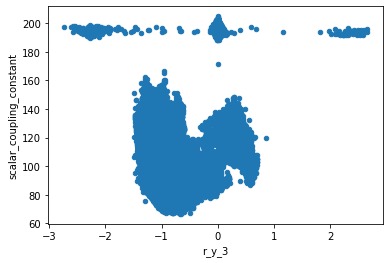

In [32]:
df.plot.scatter(x='r_y_3', y = 'scalar_coupling_constant') 

In [33]:
#X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
#y_data = df['scalar_coupling_constant'].values.astype('float32')
X_data = df.drop(['scalar_coupling_constant'], axis=1)
y_data = df['scalar_coupling_constant']


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((567532, 52), (141884, 52), (567532,), (141884,))

## LGBMRegressor

In [34]:
#aaa

In [35]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.3,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 400,
    'min_child_samples': 60,
    'max_depth': 9,
    'reg_alpha': 0.01,
    'reg_lambda': 0.3,
    'bagging_freq': 2000,
    'bagging_fraction': 0.7,
    'bagging_seed': 11,
    'colsample_bytree': 1.0
}

In [36]:
%time 
categorical_features = [col for col in X_train if col.startswith('atom_')]

model = LGBMRegressor(**LGB_PARAMS, n_estimators=100, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=1000,
         categorical_feature = categorical_features)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Wall time: 0 ns


C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 1.60781	valid_1's l1: 1.64599
Did not meet early stopping. Best iteration is:
[100]	training's l1: 1.60781	valid_1's l1: 1.64599


0.4983415454740128

Not a bad score for such a simple set of features.

In [37]:
model

LGBMRegressor(bagging_fraction=0.7, bagging_freq=2000, bagging_seed=11,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=9,
              metric='mae', min_child_samples=60, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=400,
              objective='regression', random_state=None, reg_alpha=0.01,
              reg_lambda=0.3, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [38]:
tmp = y_pred- y_val
tmp.describe()

count    141884.000000
mean     0.000084     
std      2.283513     
min     -43.735946    
25%     -1.177550     
50%      0.019702     
75%      1.225679     
max      21.078929    
Name: scalar_coupling_constant, dtype: float64

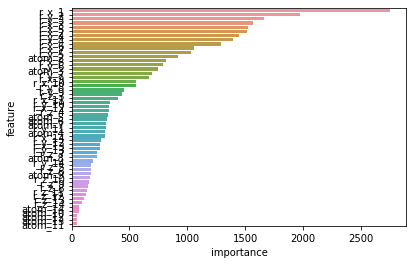

In [39]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

In [40]:
df_importance.sort_values('importance', ascending=False)

,feature,importance
13,r_x_1,2757
27,r_y_2,1974
28,r_y_3,1666
15,r_x_3,1567
17,r_x_5,1527
14,r_x_2,1520
29,r_y_4,1444
16,r_x_4,1398
18,r_x_6,1288
19,r_x_7,1056


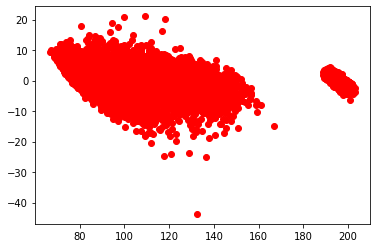

In [41]:
plt.plot(y_val, y_pred- y_val, 'ro')

In [42]:
np.power(2,9)

512

## Submission Model


In [43]:
def build_x_y_data(some_csv, coupling_type, n_atoms, isTest = False):
   #full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    if isTest:
        full_all = pd.read_csv(f'{INPUT_ADDED}/test_{coupling_type}.csv')
    else:
        full_all =  pd.read_csv(f'{INPUT_ADDED}/{coupling_type}.csv')
    full = full_all
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1)
        y_data = df['scalar_coupling_constant']
    else:
        X_data = df
        y_data = None
    
    return X_data, y_data

In [44]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=3, n_splits=3, random_state=128):
    model_type =  'lgb' #lgb  cat
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms, False)
    columns = X_data.columns 
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms, True)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')


    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        #X_train, X_val = X_data[train_index], X_data[val_index]
        #y_train, y_val = y_data[train_index], y_data[val_index]
        X_train, X_val = X_data[columns].iloc[train_index], X_data[columns].iloc[val_index]
        y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

        model = ""
        categorical_features = [col for col in X_train if col.startswith('atom_')]
        if model_type == 'lgb':

            model = LGBMRegressor(**LGB_PARAMS, n_estimators=10000, n_jobs = -1)
            #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
                verbose=100, early_stopping_rounds=1000,
                     categorical_feature = categorical_features)
        
        if model_type == 'cat': 
            model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
            X_trainGlob = X_train
            model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
                      cat_features = categorical_features,
                      use_best_model=True,
                      verbose=False)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [45]:
if False: 
    model_params = {
        '1JHC': 10,
        '1JHN': 7,    
        '2JHH': 9,
        '2JHN': 9,
        '2JHC': 9,
        '3JHH': 9,
        '3JHC': 10,
        '3JHN': 10
    }
model_params = {
        '1JHN': 10,    
        '1JHC': 15,
        '2JHH': 13,
        '2JHN': 13,
        '2JHC': 13,
        '3JHH': 13,
        '3JHC': 15,
        '3JHN': 15
    }


Checking cross-validation scores for each type:

In [46]:
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'r_x_1', 'r_x_2', 'r_x_3', 'r_x_4', 'r_x_5', 'r_x_6', 'r_x_7',
       'r_x_8', 'r_x_9', 'r_y_2', 'r_y_3', 'r_y_4', 'r_y_5', 'r_y_6', 'r_y_7',
       'r_y_8', 'r_y_9', 'r_z_3', 'r_z_4', 'r_z_5', 'r_z_6', 'r_z_7', 'r_z_8',
       'r_z_9', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'r_x_1', 'r_x_2', 'r_x_3', 'r_x_4', 'r_x_5', 'r_x_6', 'r_x_7',
       'r_x_8', 'r_x_9', 'r_y_2', 'r_y_3', 'r_y_4', 'r_y_5', 'r_y_6', 'r_y_7',
       'r_y_8', 'r_y_9', 'r_z_3', 'r_z_4', 'r_z_5', 'r_z_6', 'r_z_7', 'r_z_8',
       'r_z_9'],
      dtype='object')
Training until validation scores don't improve for 1000 rounds.


C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	training's l1: 0.595661	valid_1's l1: 0.680035
[200]	training's l1: 0.50095	valid_1's l1: 0.606997
[300]	training's l1: 0.462818	valid_1's l1: 0.581784
[400]	training's l1: 0.434137	valid_1's l1: 0.563719
[500]	training's l1: 0.412179	valid_1's l1: 0.550646
[600]	training's l1: 0.395662	valid_1's l1: 0.541894
[700]	training's l1: 0.381706	valid_1's l1: 0.534004
[800]	training's l1: 0.368874	valid_1's l1: 0.527508
[900]	training's l1: 0.357287	valid_1's l1: 0.521344
[1000]	training's l1: 0.346683	valid_1's l1: 0.516896
[1100]	training's l1: 0.337975	valid_1's l1: 0.513055
[1200]	training's l1: 0.330414	valid_1's l1: 0.510199
[1300]	training's l1: 0.322677	valid_1's l1: 0.50738
[1400]	training's l1: 0.316508	valid_1's l1: 0.504946
[1500]	training's l1: 0.3099	valid_1's l1: 0.502399
[1600]	training's l1: 0.304041	valid_1's l1: 0.500128
[1700]	training's l1: 0.298829	valid_1's l1: 0.498314
[1800]	training's l1: 0.294264	valid_1's l1: 0.49679
[1900]	training's l1: 0.290142	valid_1's l

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.593417	valid_1's l1: 0.675058
[200]	training's l1: 0.509382	valid_1's l1: 0.609108
[300]	training's l1: 0.472599	valid_1's l1: 0.583616
[400]	training's l1: 0.447028	valid_1's l1: 0.565903
[500]	training's l1: 0.424962	valid_1's l1: 0.551302
[600]	training's l1: 0.406106	valid_1's l1: 0.539606
[700]	training's l1: 0.390556	valid_1's l1: 0.530813
[800]	training's l1: 0.374971	valid_1's l1: 0.52322
[900]	training's l1: 0.361031	valid_1's l1: 0.516694
[1000]	training's l1: 0.349071	valid_1's l1: 0.510998
[1100]	training's l1: 0.338592	valid_1's l1: 0.506796
[1200]	training's l1: 0.32823	valid_1's l1: 0.502523
[1300]	training's l1: 0.320204	valid_1's l1: 0.49933
[1400]	training's l1: 0.3124	valid_1's l1: 0.496686
[1500]	training's l1: 0.30401	valid_1's l1: 0.493669
[1600]	training's l1: 0.296393	valid_1's l1: 0.491027
[1700]	training's l1: 0.289729	valid_1's l1: 0.488791
[1800]	training's l1: 0.283718	va

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.591456	valid_1's l1: 0.670075
[200]	training's l1: 0.511939	valid_1's l1: 0.606114
[300]	training's l1: 0.475046	valid_1's l1: 0.581148
[400]	training's l1: 0.448345	valid_1's l1: 0.564103
[500]	training's l1: 0.425278	valid_1's l1: 0.550201
[600]	training's l1: 0.406202	valid_1's l1: 0.53959
[700]	training's l1: 0.390766	valid_1's l1: 0.531914
[800]	training's l1: 0.376424	valid_1's l1: 0.525129
[900]	training's l1: 0.364322	valid_1's l1: 0.51941
[1000]	training's l1: 0.351953	valid_1's l1: 0.513872
[1100]	training's l1: 0.340836	valid_1's l1: 0.508972
[1200]	training's l1: 0.330564	valid_1's l1: 0.504674
[1300]	training's l1: 0.322427	valid_1's l1: 0.501661
[1400]	training's l1: 0.314297	valid_1's l1: 0.499066
[1500]	training's l1: 0.306724	valid_1's l1: 0.496207
[1600]	training's l1: 0.299787	valid_1's l1: 0.493739
[1700]	training's l1: 0.292263	valid_1's l1: 0.491098
[1800]	training's l1: 0.28604

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 1.61703	valid_1's l1: 1.65331
[200]	training's l1: 1.26377	valid_1's l1: 1.33203
[300]	training's l1: 1.11715	valid_1's l1: 1.20646
[400]	training's l1: 1.0242	valid_1's l1: 1.13136
[500]	training's l1: 0.957488	valid_1's l1: 1.08011
[600]	training's l1: 0.905254	valid_1's l1: 1.04141
[700]	training's l1: 0.864173	valid_1's l1: 1.01204
[800]	training's l1: 0.83267	valid_1's l1: 0.990718
[900]	training's l1: 0.803941	valid_1's l1: 0.971741
[1000]	training's l1: 0.780048	valid_1's l1: 0.956002
[1100]	training's l1: 0.756115	valid_1's l1: 0.941158
[1200]	training's l1: 0.735661	valid_1's l1: 0.928587
[1300]	training's l1: 0.716544	valid_1's l1: 0.917226
[1400]	training's l1: 0.699738	valid_1's l1: 0.907483
[1500]	training's l1: 0.683987	valid_1's l1: 0.898345
[1600]	training's l1: 0.669216	valid_1's l1: 0.890242
[1700]	training's l1: 0.656705	valid_1's l1: 0.883452
[1800]	training's l1: 0.643754	valid_1's

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 1.61583	valid_1's l1: 1.66255
[200]	training's l1: 1.25573	valid_1's l1: 1.32854
[300]	training's l1: 1.10822	valid_1's l1: 1.202
[400]	training's l1: 1.01738	valid_1's l1: 1.12884
[500]	training's l1: 0.95171	valid_1's l1: 1.07798
[600]	training's l1: 0.903396	valid_1's l1: 1.04244
[700]	training's l1: 0.863812	valid_1's l1: 1.01466
[800]	training's l1: 0.831055	valid_1's l1: 0.992237
[900]	training's l1: 0.80284	valid_1's l1: 0.973726
[1000]	training's l1: 0.77857	valid_1's l1: 0.958165
[1100]	training's l1: 0.755821	valid_1's l1: 0.943962
[1200]	training's l1: 0.736435	valid_1's l1: 0.932193
[1300]	training's l1: 0.717712	valid_1's l1: 0.921035
[1400]	training's l1: 0.700155	valid_1's l1: 0.910763
[1500]	training's l1: 0.684665	valid_1's l1: 0.902094
[1600]	training's l1: 0.670348	valid_1's l1: 0.894687
[1700]	training's l1: 0.656686	valid_1's l1: 0.887473
[1800]	training's l1: 0.643592	valid_1's l1

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 1.62056	valid_1's l1: 1.66525
[200]	training's l1: 1.26364	valid_1's l1: 1.33723
[300]	training's l1: 1.11427	valid_1's l1: 1.20884
[400]	training's l1: 1.01867	valid_1's l1: 1.1306
[500]	training's l1: 0.954788	valid_1's l1: 1.08084
[600]	training's l1: 0.908724	valid_1's l1: 1.04649
[700]	training's l1: 0.867326	valid_1's l1: 1.0166
[800]	training's l1: 0.834282	valid_1's l1: 0.993678
[900]	training's l1: 0.806131	valid_1's l1: 0.974742
[1000]	training's l1: 0.780738	valid_1's l1: 0.958688
[1100]	training's l1: 0.75899	valid_1's l1: 0.945057
[1200]	training's l1: 0.73948	valid_1's l1: 0.933556
[1300]	training's l1: 0.720852	valid_1's l1: 0.922744
[1400]	training's l1: 0.703745	valid_1's l1: 0.912663
[1500]	training's l1: 0.687659	valid_1's l1: 0.903599
[1600]	training's l1: 0.674191	valid_1's l1: 0.896228
[1700]	training's l1: 0.659801	valid_1's l1: 0.888488
[1800]	training's l1: 0.646919	valid_1's l

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.32679	valid_1's l1: 0.34356
[200]	training's l1: 0.267017	valid_1's l1: 0.291971
[300]	training's l1: 0.240857	valid_1's l1: 0.270956
[400]	training's l1: 0.223532	valid_1's l1: 0.257738
[500]	training's l1: 0.212325	valid_1's l1: 0.249564
[600]	training's l1: 0.202263	valid_1's l1: 0.242658
[700]	training's l1: 0.194264	valid_1's l1: 0.237322
[800]	training's l1: 0.187058	valid_1's l1: 0.232653
[900]	training's l1: 0.180633	valid_1's l1: 0.228677
[1000]	training's l1: 0.175084	valid_1's l1: 0.225334
[1100]	training's l1: 0.170132	valid_1's l1: 0.222464
[1200]	training's l1: 0.165592	valid_1's l1: 0.219956
[1300]	training's l1: 0.16169	valid_1's l1: 0.217762
[1400]	training's l1: 0.157702	valid_1's l1: 0.215656
[1500]	training's l1: 0.153899	valid_1's l1: 0.213592
[1600]	training's l1: 0.150461	valid_1's l1: 0.21182
[1700]	training's l1: 0.147267	valid_1's l1: 0.210188
[1800]	training's l1: 0.144322	

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.326968	valid_1's l1: 0.341338
[200]	training's l1: 0.267635	valid_1's l1: 0.289899
[300]	training's l1: 0.242367	valid_1's l1: 0.269199
[400]	training's l1: 0.225867	valid_1's l1: 0.256621
[500]	training's l1: 0.213505	valid_1's l1: 0.247547
[600]	training's l1: 0.202705	valid_1's l1: 0.240185
[700]	training's l1: 0.1942	valid_1's l1: 0.234693
[800]	training's l1: 0.186396	valid_1's l1: 0.229841
[900]	training's l1: 0.179637	valid_1's l1: 0.22581
[1000]	training's l1: 0.173586	valid_1's l1: 0.22226
[1100]	training's l1: 0.168363	valid_1's l1: 0.219352
[1200]	training's l1: 0.163278	valid_1's l1: 0.216555
[1300]	training's l1: 0.159145	valid_1's l1: 0.214311
[1400]	training's l1: 0.155065	valid_1's l1: 0.212153
[1500]	training's l1: 0.151405	valid_1's l1: 0.210254
[1600]	training's l1: 0.148033	valid_1's l1: 0.208595
[1700]	training's l1: 0.144765	valid_1's l1: 0.207035
[1800]	training's l1: 0.141822	

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.328378	valid_1's l1: 0.343864
[200]	training's l1: 0.267232	valid_1's l1: 0.291238
[300]	training's l1: 0.240687	valid_1's l1: 0.269849
[400]	training's l1: 0.223094	valid_1's l1: 0.256432
[500]	training's l1: 0.210749	valid_1's l1: 0.24764
[600]	training's l1: 0.200449	valid_1's l1: 0.240454
[700]	training's l1: 0.191439	valid_1's l1: 0.23446
[800]	training's l1: 0.18416	valid_1's l1: 0.229801
[900]	training's l1: 0.177716	valid_1's l1: 0.225767
[1000]	training's l1: 0.171881	valid_1's l1: 0.222117
[1100]	training's l1: 0.166872	valid_1's l1: 0.219162
[1200]	training's l1: 0.162202	valid_1's l1: 0.216501
[1300]	training's l1: 0.157872	valid_1's l1: 0.214111
[1400]	training's l1: 0.154391	valid_1's l1: 0.212255
[1500]	training's l1: 0.150829	valid_1's l1: 0.210357
[1600]	training's l1: 0.147536	valid_1's l1: 0.208592
[1700]	training's l1: 0.144374	valid_1's l1: 0.206985
[1800]	training's l1: 0.141096

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.269789	valid_1's l1: 0.29323
[200]	training's l1: 0.223892	valid_1's l1: 0.255586
[300]	training's l1: 0.20024	valid_1's l1: 0.238084
[400]	training's l1: 0.184531	valid_1's l1: 0.227014
[500]	training's l1: 0.172643	valid_1's l1: 0.219362
[600]	training's l1: 0.163549	valid_1's l1: 0.214005
[700]	training's l1: 0.155769	valid_1's l1: 0.209533
[800]	training's l1: 0.148512	valid_1's l1: 0.205773
[900]	training's l1: 0.142339	valid_1's l1: 0.202434
[1000]	training's l1: 0.137231	valid_1's l1: 0.200039
[1100]	training's l1: 0.132614	valid_1's l1: 0.197856
[1200]	training's l1: 0.128746	valid_1's l1: 0.196032
[1300]	training's l1: 0.125007	valid_1's l1: 0.194194
[1400]	training's l1: 0.121762	valid_1's l1: 0.19269
[1500]	training's l1: 0.1189	valid_1's l1: 0.191436
[1600]	training's l1: 0.116059	valid_1's l1: 0.190229
[1700]	training's l1: 0.113429	valid_1's l1: 0.189194
[1800]	training's l1: 0.11092	va

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.271759	valid_1's l1: 0.288613
[200]	training's l1: 0.223629	valid_1's l1: 0.248914
[300]	training's l1: 0.201351	valid_1's l1: 0.232405
[400]	training's l1: 0.18508	valid_1's l1: 0.221352
[500]	training's l1: 0.172535	valid_1's l1: 0.213542
[600]	training's l1: 0.163135	valid_1's l1: 0.207834
[700]	training's l1: 0.155481	valid_1's l1: 0.203717
[800]	training's l1: 0.148324	valid_1's l1: 0.199934
[900]	training's l1: 0.142156	valid_1's l1: 0.1967
[1000]	training's l1: 0.137074	valid_1's l1: 0.194199
[1100]	training's l1: 0.132565	valid_1's l1: 0.192198
[1200]	training's l1: 0.128282	valid_1's l1: 0.190231
[1300]	training's l1: 0.12464	valid_1's l1: 0.188635
[1400]	training's l1: 0.121281	valid_1's l1: 0.187248
[1500]	training's l1: 0.118042	valid_1's l1: 0.18585
[1600]	training's l1: 0.115185	valid_1's l1: 0.184728
[1700]	training's l1: 0.112341	valid_1's l1: 0.183687
[1800]	training's l1: 0.109872	v

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.280779	valid_1's l1: 0.296716
[200]	training's l1: 0.228372	valid_1's l1: 0.253007
[300]	training's l1: 0.20255	valid_1's l1: 0.234348
[400]	training's l1: 0.186695	valid_1's l1: 0.223668
[500]	training's l1: 0.174263	valid_1's l1: 0.215613
[600]	training's l1: 0.16514	valid_1's l1: 0.209931
[700]	training's l1: 0.156548	valid_1's l1: 0.204696
[800]	training's l1: 0.149586	valid_1's l1: 0.2011
[900]	training's l1: 0.143315	valid_1's l1: 0.197779
[1000]	training's l1: 0.137855	valid_1's l1: 0.195045
[1100]	training's l1: 0.132893	valid_1's l1: 0.19269
[1200]	training's l1: 0.128742	valid_1's l1: 0.190668
[1300]	training's l1: 0.124932	valid_1's l1: 0.188936
[1400]	training's l1: 0.121527	valid_1's l1: 0.187425
[1500]	training's l1: 0.118643	valid_1's l1: 0.186251
[1600]	training's l1: 0.11564	valid_1's l1: 0.185058
[1700]	training's l1: 0.112781	valid_1's l1: 0.183897
[1800]	training's l1: 0.110312	va

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.658862	valid_1's l1: 0.669302
[200]	training's l1: 0.524415	valid_1's l1: 0.542133
[300]	training's l1: 0.467524	valid_1's l1: 0.490652
[400]	training's l1: 0.431551	valid_1's l1: 0.459585
[500]	training's l1: 0.404724	valid_1's l1: 0.437157
[600]	training's l1: 0.38462	valid_1's l1: 0.420762
[700]	training's l1: 0.369288	valid_1's l1: 0.408814
[800]	training's l1: 0.356342	valid_1's l1: 0.39879
[900]	training's l1: 0.344726	valid_1's l1: 0.390205
[1000]	training's l1: 0.334377	valid_1's l1: 0.382503
[1100]	training's l1: 0.326122	valid_1's l1: 0.37655
[1200]	training's l1: 0.31824	valid_1's l1: 0.371007
[1300]	training's l1: 0.311486	valid_1's l1: 0.366382
[1400]	training's l1: 0.304453	valid_1's l1: 0.361512
[1500]	training's l1: 0.298292	valid_1's l1: 0.357485
[1600]	training's l1: 0.292489	valid_1's l1: 0.353667
[1700]	training's l1: 0.287602	valid_1's l1: 0.350557
[1800]	training's l1: 0.282817	

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.651838	valid_1's l1: 0.665242
[200]	training's l1: 0.521942	valid_1's l1: 0.54315
[300]	training's l1: 0.465875	valid_1's l1: 0.492149
[400]	training's l1: 0.431617	valid_1's l1: 0.461886
[500]	training's l1: 0.407896	valid_1's l1: 0.441674
[600]	training's l1: 0.387796	valid_1's l1: 0.42511
[700]	training's l1: 0.372615	valid_1's l1: 0.413032
[800]	training's l1: 0.359883	valid_1's l1: 0.403152
[900]	training's l1: 0.348469	valid_1's l1: 0.394468
[1000]	training's l1: 0.337949	valid_1's l1: 0.386647
[1100]	training's l1: 0.328705	valid_1's l1: 0.379988
[1200]	training's l1: 0.32106	valid_1's l1: 0.37456
[1300]	training's l1: 0.314225	valid_1's l1: 0.370031
[1400]	training's l1: 0.307587	valid_1's l1: 0.365559
[1500]	training's l1: 0.301459	valid_1's l1: 0.361518
[1600]	training's l1: 0.295661	valid_1's l1: 0.357704
[1700]	training's l1: 0.290487	valid_1's l1: 0.354379
[1800]	training's l1: 0.285214	

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.651393	valid_1's l1: 0.662877
[200]	training's l1: 0.520146	valid_1's l1: 0.539905
[300]	training's l1: 0.46554	valid_1's l1: 0.490431
[400]	training's l1: 0.431566	valid_1's l1: 0.461134
[500]	training's l1: 0.406712	valid_1's l1: 0.440116
[600]	training's l1: 0.387532	valid_1's l1: 0.424757
[700]	training's l1: 0.372413	valid_1's l1: 0.412751
[800]	training's l1: 0.358334	valid_1's l1: 0.401837
[900]	training's l1: 0.347672	valid_1's l1: 0.393813
[1000]	training's l1: 0.338247	valid_1's l1: 0.387009
[1100]	training's l1: 0.329534	valid_1's l1: 0.380707
[1200]	training's l1: 0.321349	valid_1's l1: 0.374903
[1300]	training's l1: 0.314006	valid_1's l1: 0.369784
[1400]	training's l1: 0.307801	valid_1's l1: 0.365749
[1500]	training's l1: 0.301927	valid_1's l1: 0.361837
[1600]	training's l1: 0.295827	valid_1's l1: 0.357763
[1700]	training's l1: 0.290005	valid_1's l1: 0.353998
[1800]	training's l1: 0.2849

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.323254	valid_1's l1: 0.332075
[200]	training's l1: 0.272794	valid_1's l1: 0.286579
[300]	training's l1: 0.248424	valid_1's l1: 0.265607
[400]	training's l1: 0.229921	valid_1's l1: 0.250239
[500]	training's l1: 0.216253	valid_1's l1: 0.239249
[600]	training's l1: 0.205487	valid_1's l1: 0.230986
[700]	training's l1: 0.196787	valid_1's l1: 0.224482
[800]	training's l1: 0.189754	valid_1's l1: 0.219455
[900]	training's l1: 0.183365	valid_1's l1: 0.214999
[1000]	training's l1: 0.177945	valid_1's l1: 0.211448
[1100]	training's l1: 0.17305	valid_1's l1: 0.208284
[1200]	training's l1: 0.168882	valid_1's l1: 0.205684
[1300]	training's l1: 0.165047	valid_1's l1: 0.203316
[1400]	training's l1: 0.161381	valid_1's l1: 0.201165
[1500]	training's l1: 0.157959	valid_1's l1: 0.199142
[1600]	training's l1: 0.154683	valid_1's l1: 0.197236
[1700]	training's l1: 0.151694	valid_1's l1: 0.195548
[1800]	training's l1: 0.1489

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.318827	valid_1's l1: 0.328688
[200]	training's l1: 0.269746	valid_1's l1: 0.284035
[300]	training's l1: 0.246028	valid_1's l1: 0.263393
[400]	training's l1: 0.229818	valid_1's l1: 0.25
[500]	training's l1: 0.217873	valid_1's l1: 0.240518
[600]	training's l1: 0.208127	valid_1's l1: 0.233104
[700]	training's l1: 0.199522	valid_1's l1: 0.2267
[800]	training's l1: 0.192586	valid_1's l1: 0.221744
[900]	training's l1: 0.186235	valid_1's l1: 0.217318
[1000]	training's l1: 0.180841	valid_1's l1: 0.213718
[1100]	training's l1: 0.175928	valid_1's l1: 0.210486
[1200]	training's l1: 0.171398	valid_1's l1: 0.207671
[1300]	training's l1: 0.16701	valid_1's l1: 0.204984
[1400]	training's l1: 0.163285	valid_1's l1: 0.202636
[1500]	training's l1: 0.159817	valid_1's l1: 0.200608
[1600]	training's l1: 0.156579	valid_1's l1: 0.198654
[1700]	training's l1: 0.153602	valid_1's l1: 0.197032
[1800]	training's l1: 0.150713	val

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.321347	valid_1's l1: 0.330068
[200]	training's l1: 0.272635	valid_1's l1: 0.286358
[300]	training's l1: 0.246774	valid_1's l1: 0.263703
[400]	training's l1: 0.230153	valid_1's l1: 0.249968
[500]	training's l1: 0.21719	valid_1's l1: 0.23971
[600]	training's l1: 0.206937	valid_1's l1: 0.231916
[700]	training's l1: 0.198574	valid_1's l1: 0.225887
[800]	training's l1: 0.191468	valid_1's l1: 0.220764
[900]	training's l1: 0.185162	valid_1's l1: 0.21639
[1000]	training's l1: 0.179318	valid_1's l1: 0.212549
[1100]	training's l1: 0.174204	valid_1's l1: 0.209223
[1200]	training's l1: 0.169902	valid_1's l1: 0.206579
[1300]	training's l1: 0.165827	valid_1's l1: 0.204089
[1400]	training's l1: 0.16212	valid_1's l1: 0.201907
[1500]	training's l1: 0.158657	valid_1's l1: 0.199891
[1600]	training's l1: 0.15539	valid_1's l1: 0.197974
[1700]	training's l1: 0.152327	valid_1's l1: 0.196223
[1800]	training's l1: 0.149335	v

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.621158	valid_1's l1: 0.63125
[200]	training's l1: 0.523015	valid_1's l1: 0.53834
[300]	training's l1: 0.479319	valid_1's l1: 0.498484
[400]	training's l1: 0.447118	valid_1's l1: 0.4701
[500]	training's l1: 0.423923	valid_1's l1: 0.450413
[600]	training's l1: 0.406709	valid_1's l1: 0.436168
[700]	training's l1: 0.392632	valid_1's l1: 0.424952
[800]	training's l1: 0.381166	valid_1's l1: 0.416234
[900]	training's l1: 0.369979	valid_1's l1: 0.407545
[1000]	training's l1: 0.359982	valid_1's l1: 0.400182
[1100]	training's l1: 0.351226	valid_1's l1: 0.393639
[1200]	training's l1: 0.343503	valid_1's l1: 0.388177
[1300]	training's l1: 0.336003	valid_1's l1: 0.382876
[1400]	training's l1: 0.32926	valid_1's l1: 0.378191
[1500]	training's l1: 0.322905	valid_1's l1: 0.37389
[1600]	training's l1: 0.317419	valid_1's l1: 0.370305
[1700]	training's l1: 0.312168	valid_1's l1: 0.366839
[1800]	training's l1: 0.307054	va

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.621979	valid_1's l1: 0.632212
[200]	training's l1: 0.522221	valid_1's l1: 0.537978
[300]	training's l1: 0.478026	valid_1's l1: 0.498113
[400]	training's l1: 0.44779	valid_1's l1: 0.471513
[500]	training's l1: 0.424733	valid_1's l1: 0.451697
[600]	training's l1: 0.407233	valid_1's l1: 0.437178
[700]	training's l1: 0.392366	valid_1's l1: 0.425188
[800]	training's l1: 0.380236	valid_1's l1: 0.415748
[900]	training's l1: 0.369227	valid_1's l1: 0.407385
[1000]	training's l1: 0.359479	valid_1's l1: 0.399928
[1100]	training's l1: 0.351349	valid_1's l1: 0.393938
[1200]	training's l1: 0.343784	valid_1's l1: 0.38853
[1300]	training's l1: 0.336591	valid_1's l1: 0.383389
[1400]	training's l1: 0.330422	valid_1's l1: 0.379214
[1500]	training's l1: 0.32424	valid_1's l1: 0.374949
[1600]	training's l1: 0.318475	valid_1's l1: 0.371162
[1700]	training's l1: 0.313147	valid_1's l1: 0.367697
[1800]	training's l1: 0.308212

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.622624	valid_1's l1: 0.633764
[200]	training's l1: 0.520455	valid_1's l1: 0.537579
[300]	training's l1: 0.477532	valid_1's l1: 0.498626
[400]	training's l1: 0.447495	valid_1's l1: 0.472008
[500]	training's l1: 0.424724	valid_1's l1: 0.452629
[600]	training's l1: 0.406689	valid_1's l1: 0.437557
[700]	training's l1: 0.391606	valid_1's l1: 0.425459
[800]	training's l1: 0.379466	valid_1's l1: 0.415848
[900]	training's l1: 0.368864	valid_1's l1: 0.407858
[1000]	training's l1: 0.359286	valid_1's l1: 0.400703
[1100]	training's l1: 0.351038	valid_1's l1: 0.394763
[1200]	training's l1: 0.343568	valid_1's l1: 0.389444
[1300]	training's l1: 0.336142	valid_1's l1: 0.384255
[1400]	training's l1: 0.329685	valid_1's l1: 0.379756
[1500]	training's l1: 0.323796	valid_1's l1: 0.375829
[1600]	training's l1: 0.318231	valid_1's l1: 0.372151
[1700]	training's l1: 0.313334	valid_1's l1: 0.368982
[1800]	training's l1: 0.308

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.208741	valid_1's l1: 0.223863
[200]	training's l1: 0.176328	valid_1's l1: 0.197332
[300]	training's l1: 0.158458	valid_1's l1: 0.184723
[400]	training's l1: 0.146232	valid_1's l1: 0.176713
[500]	training's l1: 0.136886	valid_1's l1: 0.171119
[600]	training's l1: 0.129683	valid_1's l1: 0.166971
[700]	training's l1: 0.12339	valid_1's l1: 0.163612
[800]	training's l1: 0.118348	valid_1's l1: 0.161228
[900]	training's l1: 0.113375	valid_1's l1: 0.158953
[1000]	training's l1: 0.109087	valid_1's l1: 0.157075
[1100]	training's l1: 0.105183	valid_1's l1: 0.155482
[1200]	training's l1: 0.101541	valid_1's l1: 0.153919
[1300]	training's l1: 0.0985799	valid_1's l1: 0.1528
[1400]	training's l1: 0.0956796	valid_1's l1: 0.151785
[1500]	training's l1: 0.093155	valid_1's l1: 0.150922
[1600]	training's l1: 0.0906393	valid_1's l1: 0.150109
[1700]	training's l1: 0.0884213	valid_1's l1: 0.149328
[1800]	training's l1: 0.08

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.206438	valid_1's l1: 0.223199
[200]	training's l1: 0.173979	valid_1's l1: 0.197216
[300]	training's l1: 0.156746	valid_1's l1: 0.184868
[400]	training's l1: 0.144556	valid_1's l1: 0.177161
[500]	training's l1: 0.135011	valid_1's l1: 0.171283
[600]	training's l1: 0.127276	valid_1's l1: 0.167066
[700]	training's l1: 0.121147	valid_1's l1: 0.163921
[800]	training's l1: 0.11617	valid_1's l1: 0.161558
[900]	training's l1: 0.111421	valid_1's l1: 0.159261
[1000]	training's l1: 0.107755	valid_1's l1: 0.15757
[1100]	training's l1: 0.104132	valid_1's l1: 0.156031
[1200]	training's l1: 0.100686	valid_1's l1: 0.15463
[1300]	training's l1: 0.0977518	valid_1's l1: 0.153459
[1400]	training's l1: 0.0949924	valid_1's l1: 0.152415
[1500]	training's l1: 0.0924589	valid_1's l1: 0.151464
[1600]	training's l1: 0.0899486	valid_1's l1: 0.150592
[1700]	training's l1: 0.0876754	valid_1's l1: 0.149835
[1800]	training's l1: 0.0

C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.208494	valid_1's l1: 0.225044
[200]	training's l1: 0.17427	valid_1's l1: 0.197542
[300]	training's l1: 0.156468	valid_1's l1: 0.184948
[400]	training's l1: 0.144543	valid_1's l1: 0.177156
[500]	training's l1: 0.135386	valid_1's l1: 0.17173
[600]	training's l1: 0.128244	valid_1's l1: 0.16766
[700]	training's l1: 0.122258	valid_1's l1: 0.164432
[800]	training's l1: 0.116776	valid_1's l1: 0.161554
[900]	training's l1: 0.111553	valid_1's l1: 0.159081
[1000]	training's l1: 0.10724	valid_1's l1: 0.157011
[1100]	training's l1: 0.103363	valid_1's l1: 0.155376
[1200]	training's l1: 0.100088	valid_1's l1: 0.154038
[1300]	training's l1: 0.096911	valid_1's l1: 0.15281
[1400]	training's l1: 0.0941978	valid_1's l1: 0.15178
[1500]	training's l1: 0.0917038	valid_1's l1: 0.150837
[1600]	training's l1: 0.0893208	valid_1's l1: 0.14995
[1700]	training's l1: 0.0869548	valid_1's l1: 0.149184
[1800]	training's l1: 0.085056

In [47]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

,type,cv_score
0,1JHN,-0.837573
1,1JHC,-0.312970
2,2JHH,-1.751563
3,2JHN,-1.828418
4,2JHC,-1.275723
5,3JHH,-1.839542
6,3JHC,-1.225006
7,3JHN,-2.018859


And cv mean score:

In [48]:
np.mean(list(cv_scores.values()))

-1.3862067347999287

Sanity check for all cells to be filled with predictions:

In [49]:
submission[submission['scalar_coupling_constant'] == 0].shape

(0, 1)

In [50]:
submission.head(10)

,scalar_coupling_constant
id,
4658147,13.625594
4658148,183.647156
4658149,-0.077270
4658150,183.647156
4658151,13.625594
4658152,91.264854
4658153,2.290939
4658154,-7.328668
4658155,-9.696672


In [51]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## a!!!